# Field inference for multiple dipole sources

This notebook demonstrates that it is possible to learn analytical forms like the dipole field with good accuracy with a physically credible network and desirable scaling behaviour. In this demonstration, we want to model the potential/field from multiple fixed sources at arbitrary field points, and to do so while running over the sources and inference points separately; i.e. O(M + N) and not O(M * N).

We suppose this to be possible because of the principle of superposition for potentials / fields, and our implementation separately the input of magnetic sources (the 'priming' network) from the inference ('main' network). In particular, we try learning a hypernetwork where the role of the priming network is to output the weights for the main network. We will use jax, equinox and optax to develop a model combining neural and analytical (autodiff) components.

In [1]:
import matplotlib.pyplot as plt
import optax
import scienceplots  # noqa
from hypermagnetics import plots
from hypermagnetics.models.hyper_mlp import HyperLayer
from hypermagnetics.runner import fit
from hypermagnetics.sources import configure

plt.style.use(["science", "ieee"])

## I. Target definition and data generation

We expect the neural components of the model to learn transcendental functions. The dipole field at $\mathbf{r}$ from a collection of point-like sources with moments $\mathbf{m}_i$ and positions $\mathbf{r}_i$ is computed via the scalar potential as $${\mu_0}\mathbf{H}_{\odot}(\mathbf{r}) = -\nabla\sum_{i=1}^N \underbrace{\overbrace{\frac{1}{2\pi |\mathbf{r}-\mathbf{r_i}|}}^{\text{Surface of 2D ball}}\overbrace{\frac{\mathbf{m}_i\cdot(\mathbf{r}-\mathbf{r_i})}{|\mathbf{r}-\mathbf{r_i}|}}^{\text{dipole term}}}_{\text{scalar potential }\psi_i}$$. 

A realistic (non-pointlike) source will have, in two dimensions, the form $\mathbf{H}(\mathbf{r}) = - \mathbb{N}(\mathbf{r})\mathbf{M}$ inside the source, and by Gauss' Law $\mathbf{H} \sim \mathbf{H}_\odot$ outside it. The distinguishing feature of the dipole term is the $\sim 1/r$ dependence; higher multipole terms ($1/r^2$, $1/r^3$) might also be included, but the dipole term will quickly dominate at larger $r$. 

We generate random samples to serve as the training data, precomputing the target potential values. Using a fixed training set helps with the stability of training, but we refresh the validation set each time its accuracy computation is needed. First, we describe the collection of sources.

In [6]:
source_config = {
    "n_samples": 1000,
    "lim": 3,
    "res": 16,
}
train = configure(**source_config, n_sources=1, seed=40)
val = configure(**source_config, n_sources=4, seed=41)

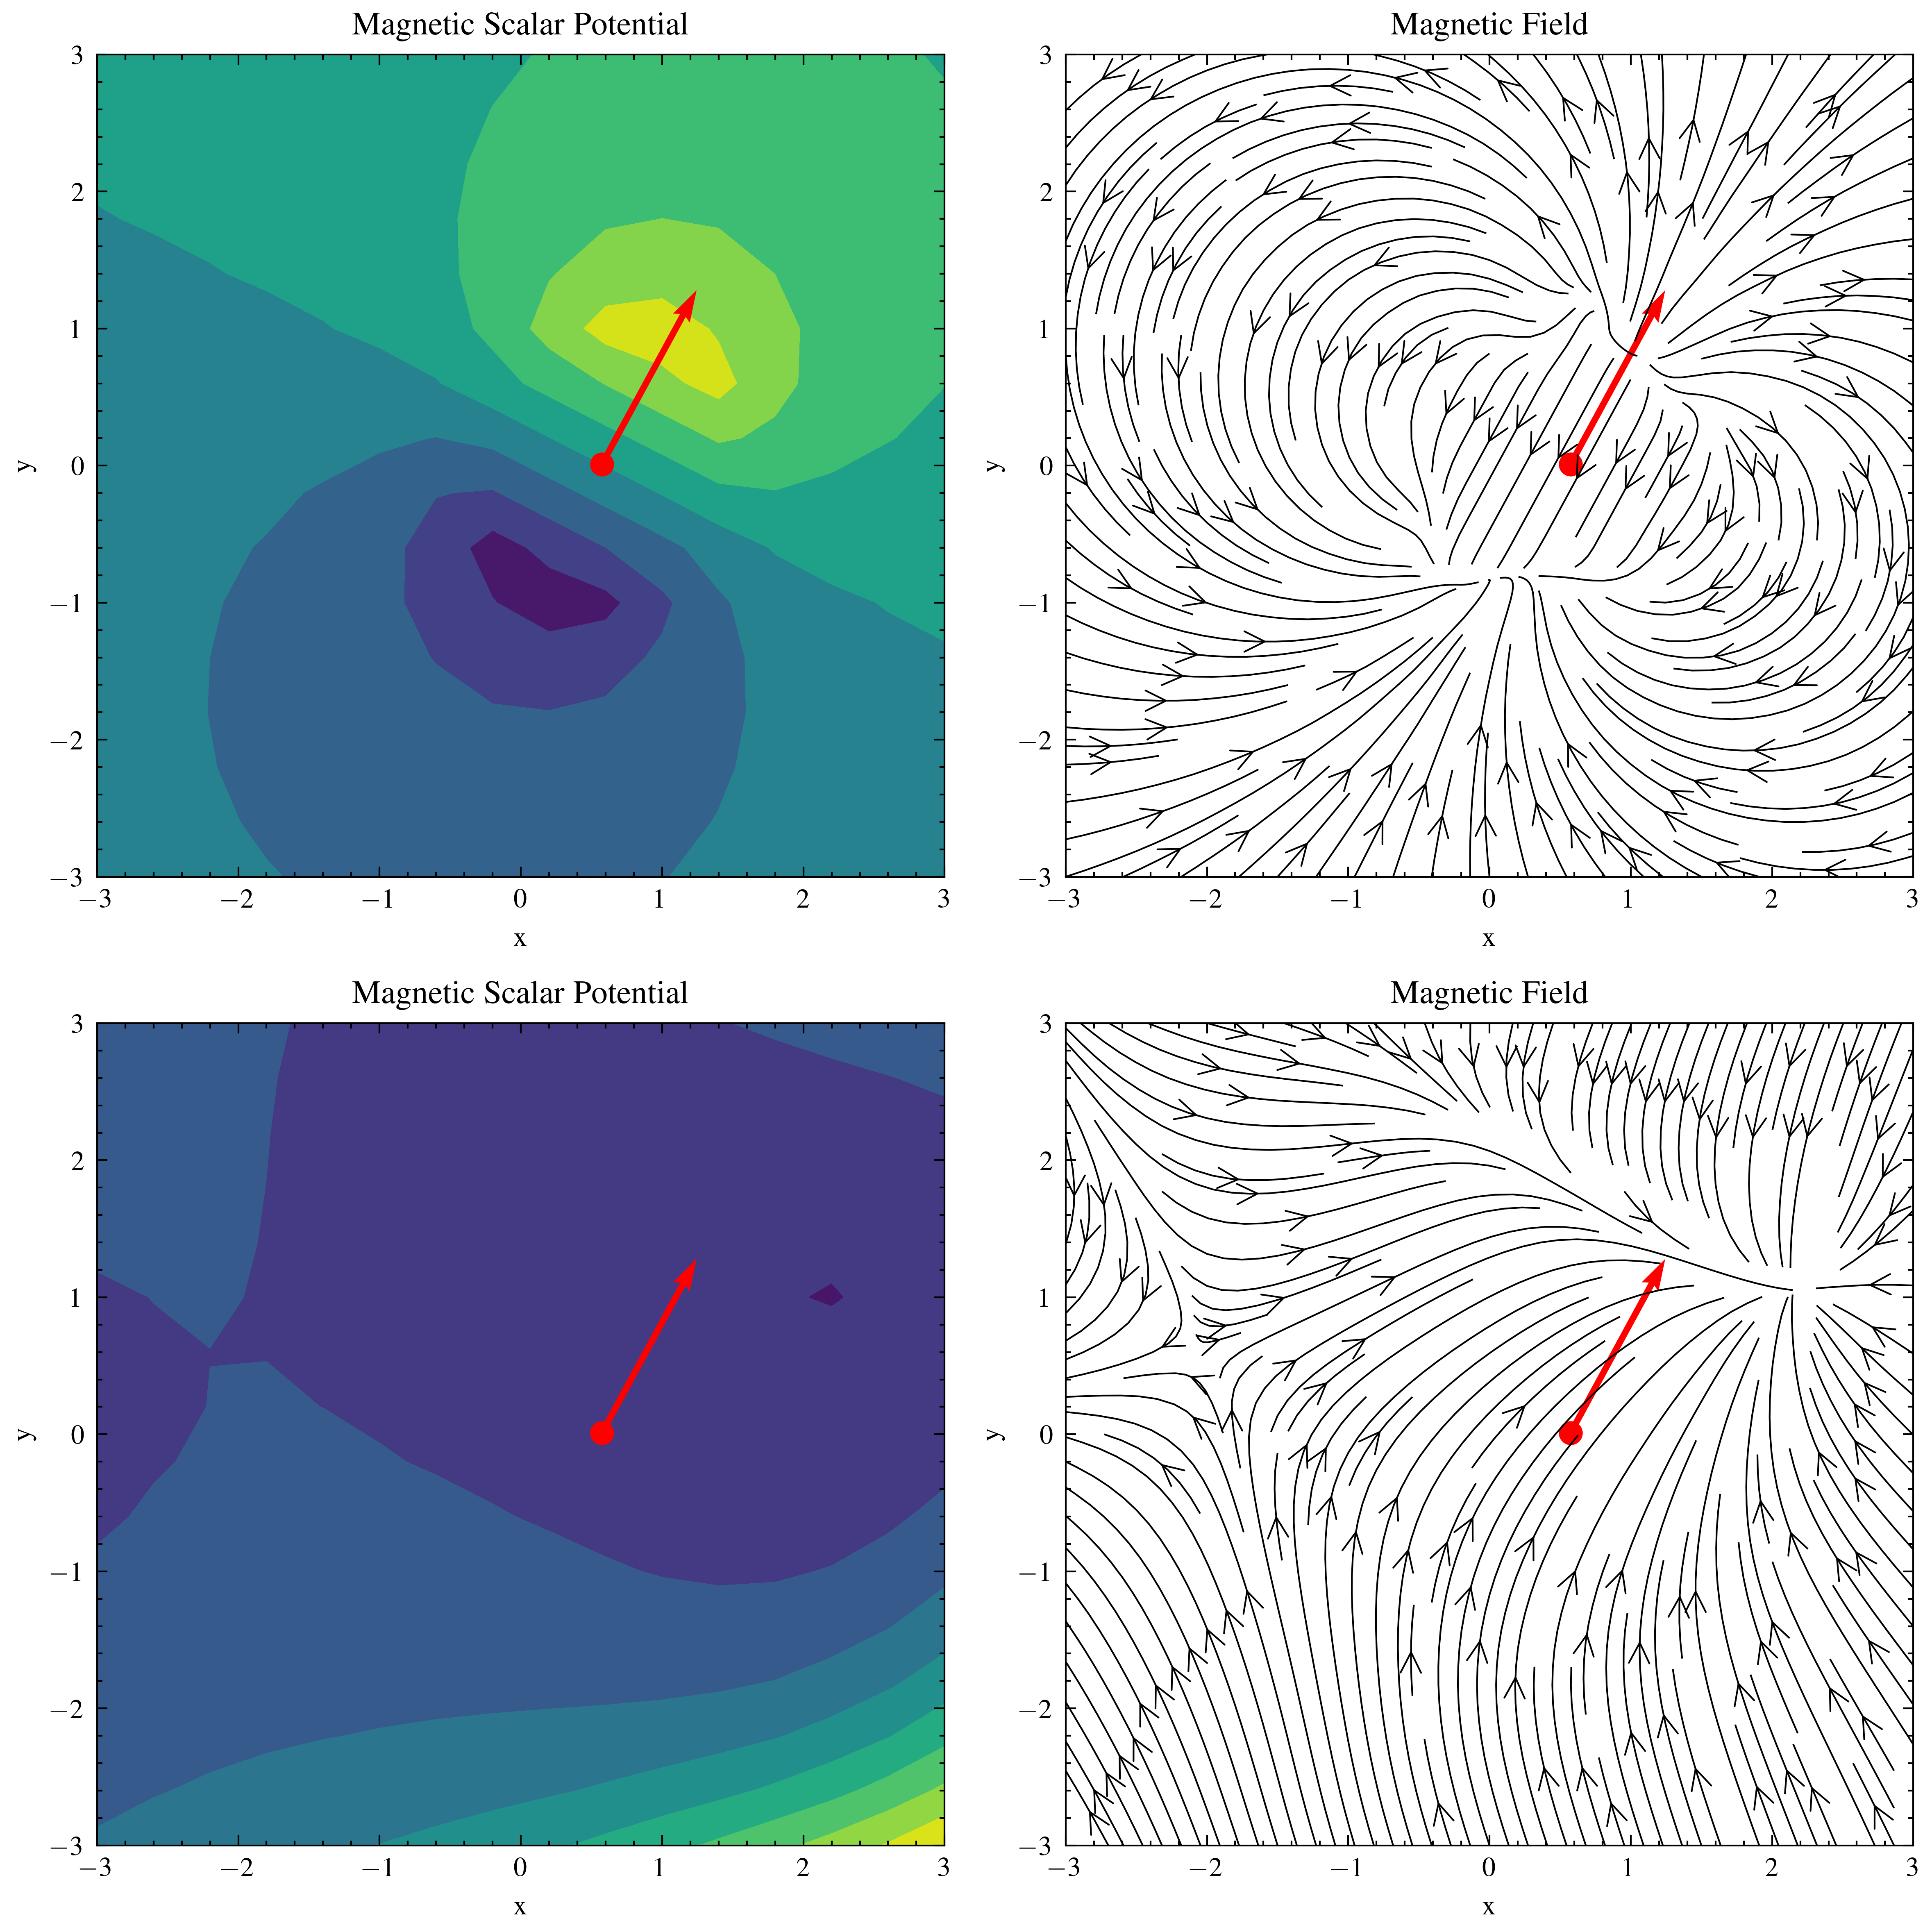

In [3]:
model = HyperLayer(20, 3, 2, 3, seed=41)
plots(train, model=model)

In [4]:
trainer_config = {"log_learning_rate": -4.5, "epochs": 20000}
learning_rate = 10 ** trainer_config["log_learning_rate"]
optim = optax.adam(learning_rate, b1=0.95)
model = fit(trainer_config, optim, model, train, val, every=100)

{'epoch': 0, 'train_loss': 0.006201210431754589, 'train_err': 115.22215270996094, 'test_err': 162.64210510253906}
{'epoch': 100, 'train_loss': 0.005179460160434246, 'train_err': 100.0793228149414, 'test_err': 100.77561950683594}
{'epoch': 200, 'train_loss': 0.0050692493095994, 'train_err': 98.33216857910156, 'test_err': 98.7654800415039}
{'epoch': 300, 'train_loss': 0.004998373799026012, 'train_err': 97.203125, 'test_err': 97.58950805664062}
{'epoch': 400, 'train_loss': 0.004914999008178711, 'train_err': 95.86181640625, 'test_err': 96.21678161621094}
{'epoch': 500, 'train_loss': 0.00479716993868351, 'train_err': 93.93416595458984, 'test_err': 94.19295501708984}
{'epoch': 600, 'train_loss': 0.004623688291758299, 'train_err': 90.99501037597656, 'test_err': 91.05728912353516}
{'epoch': 700, 'train_loss': 0.004420146811753511, 'train_err': 87.37129211425781, 'test_err': 87.2701644897461}
{'epoch': 800, 'train_loss': 0.004257155116647482, 'train_err': 84.43197631835938, 'test_err': 84.53796

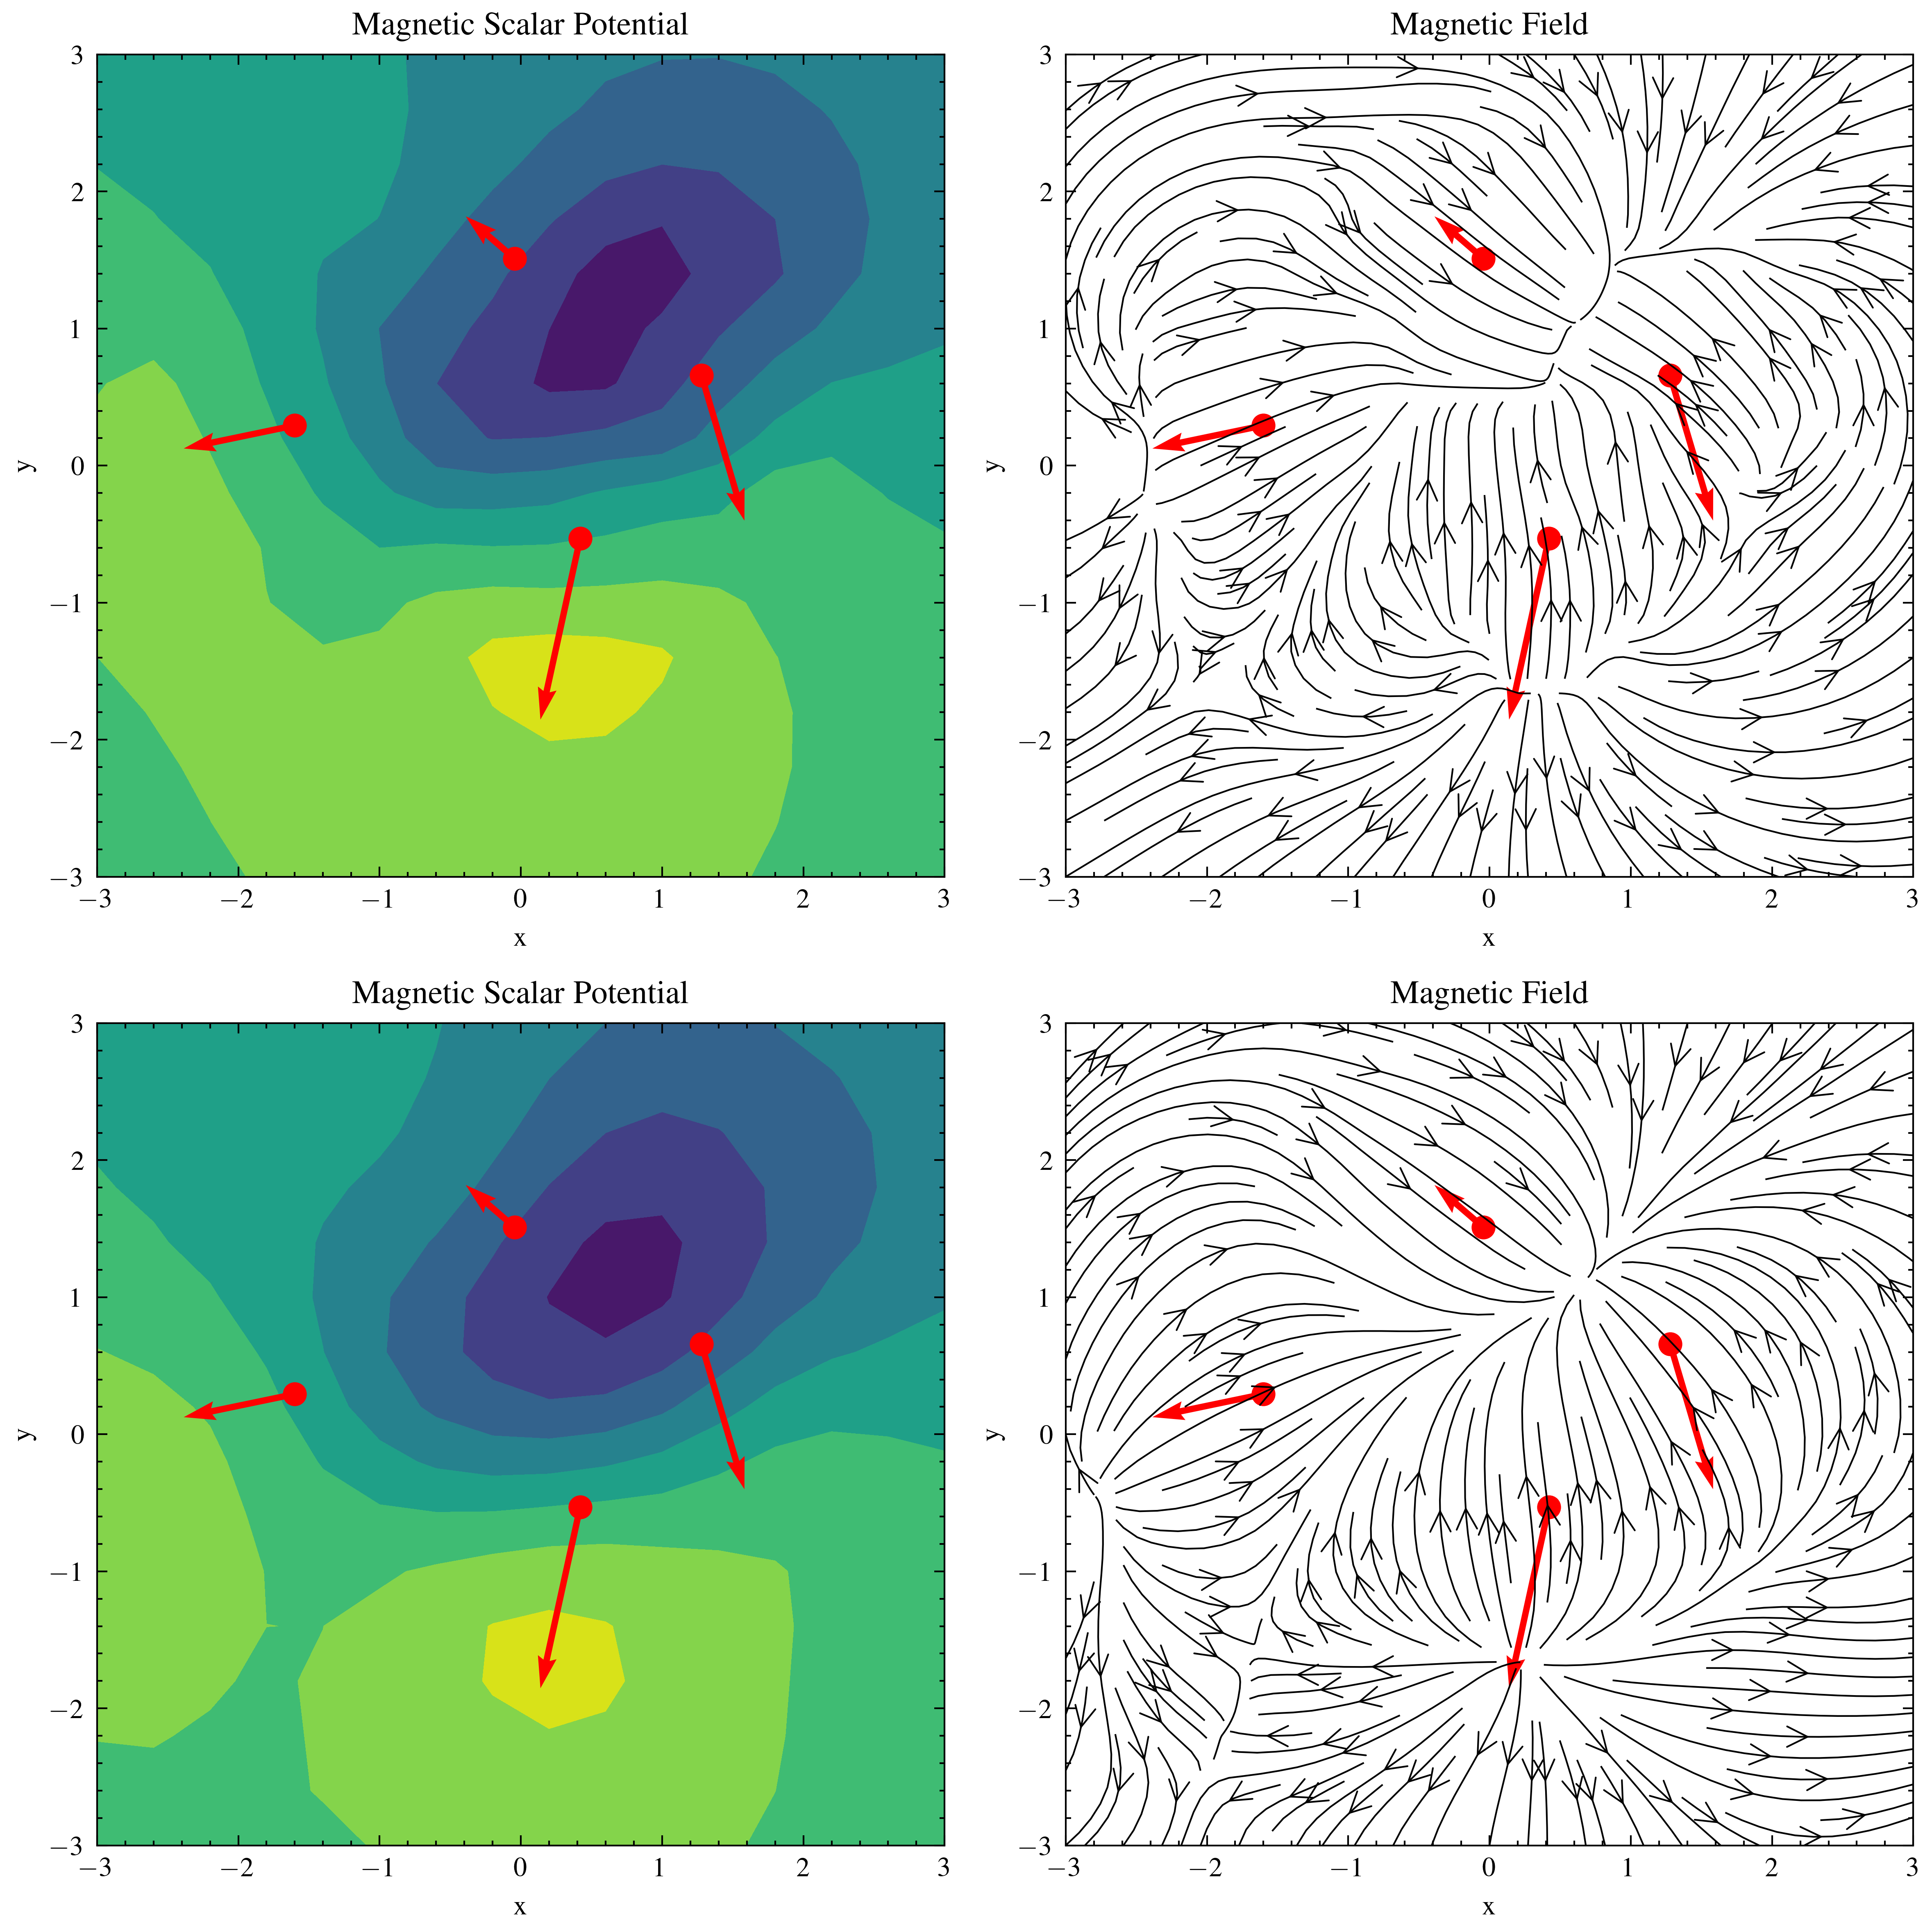

In [7]:
plots(val, model=model)

## II. Inference

To start with, let's show that we can model the potential for this static source configuration, generalising to new field points without making any attempt at learning how the sources influence it. The grid points and evaluations we've used for plotting above are ready to be used as training data. We train an MLP network of fixed size to learn $\mu_0 \mathbf{H}$, using the relative geometric error as the target measure of accuracy. 